### Created on 2025
### @author: S.W

In [1]:
# 강화학습 입문하기 
# Chapter 1: 순차적 의사결정과 Multi-Armed Bandit
# Chapter 2: 마르코프 프로세스 (MP) → 마르코프 보상 프로세스 (MRP) → 마르코프 결정 프로세스 (MDP)  
# Chapter 3: 벨만 방정식 기초

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib import font_manager
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (한국어 출력용)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.unicode_minus'] = False

# plt.rcParams['font.family'] = 'Noto Sans CJK KR'
# plt.rcParams['figure.figsize'] = (10, 6)
# plt.rcParams['axes.unicode_minus'] = False

## Chapter 1: 순차적 의사결정과 Multi-Armed Bandit

### Multi-Armed Bandit 문제 정의
- Multi-Armed Bandit은 강화학습의 가장 기본적인 문제 중 하나로, 여러 개의 슬롯머신(팔이 여러 개인 도박 기계) 중에서 어떤 것을 선택해야 최대 수익을 얻을 수 있는지를 결정하는 문제

- 상황: 카지노에 3개의 슬롯머신이 있습니다
    - 슬롯머신 A: 평균 30% 확률로 당첨 (모름)
    - 슬롯머신 B: 평균 70% 확률로 당첨 (모름) ← 최고!
    - 슬롯머신 C: 평균 50% 확률로 당첨 (모름)

문제: 어떤 머신의 당첨률이 높은지 모르는 상태에서
      최대한 많은 돈을 따려면 어떻게 해야 할까?

In [2]:
# Multi-Armed Bandit 환경 설정

# 슬롯머신 개수와 각각의 평균 보상 정의
n_arms = 3
true_rewards = [0.3, 0.7, 0.5]  # 각 슬롯머신의 진짜 평균 보상
arm_names = ['슬롯머신 A', '슬롯머신 B', '슬롯머신 C']

print(f"슬롯머신 개수: {n_arms}개")
print(f"각 머신의 실제 평균 보상: {true_rewards}")
print(f"목표: 가장 높은 보상을 주는 머신을 찾기")

슬롯머신 개수: 3개
각 머신의 실제 평균 보상: [0.3, 0.7, 0.5]
목표: 가장 높은 보상을 주는 머신을 찾기


In [3]:
# 각 슬롯머신에서 보상을 받는 함수
def get_reward(arm_index):
    """선택한 슬롯머신에서 보상을 받는 함수"""
    mean_reward = true_rewards[arm_index]
    
    # 베르누이 분포: 확률로 1 또는 0 반환
    reward = np.random.binomial(1, mean_reward)
    return reward

# 테스트: 각 머신에서 10번씩 보상 받아보기
for i in range(n_arms):
    test_rewards = []
    for _ in range(10): # 10회 테스트
        reward = get_reward(i)
        test_rewards.append(reward)
    
    avg_reward = np.mean(test_rewards)
    print(f"{arm_names[i]}: 보상 = {test_rewards}")
    print(f"    → 평균 보상: {avg_reward:.2f} (실제: {true_rewards[i]})")

슬롯머신 A: 보상 = [0, 1, 0, 0, 0, 1, 1, 0, 0, 0]
    → 평균 보상: 0.30 (실제: 0.3)
슬롯머신 B: 보상 = [0, 1, 1, 1, 1, 1, 0, 0, 0, 1]
    → 평균 보상: 0.60 (실제: 0.7)
슬롯머신 C: 보상 = [0, 0, 0, 0, 0, 1, 1, 1, 0, 0]
    → 평균 보상: 0.30 (실제: 0.5)


### 핵심 딜레마: 탐험 vs 활용
**탐험 (Exploration)** <br>
"다른 머신도 시도해봐야지!"<br>
새로운 정보를 얻기 위해 다양한 선택 시도<br>
단기적으로는 손해를 볼 수 있음<br>
<br>
**활용 (Exploitation)** <br>
"지금까지 가장 좋았던 머신만 계속 사용하자!"<br>
현재까지 알고 있는 최선의 선택만 반복<br>
더 좋은 선택을 놓칠 수 있음<br>

In [4]:
# 실험 설정
n_rounds = 100
np.random.seed(42)  # 재현가능한 결과를 위한 시드 설정

🎲 전략 1: 랜덤 선택 (순수 탐험)<br>
- 특징: 모든 머신을 동일한 확률로 선택<br>
- 장점: 모든 선택지를 공평하게 탐험<br>
- 단점: 좋은 머신을 찾아도 활용하지 않음<br>

In [5]:
def random_strategy(n_rounds):
    """랜덤하게 슬롯머신을 선택하는 전략"""
    total_reward = 0
    rewards_history = []
    choices_history = []
    
    for round_num in range(n_rounds):
        # 랜덤하게 머신 선택
        chosen_arm = np.random.randint(0, n_arms)
        choices_history.append(chosen_arm)
        
        # 보상 받기
        reward = get_reward(chosen_arm)
        total_reward += reward
        rewards_history.append(total_reward)
    
    return total_reward, rewards_history, choices_history

# 랜덤 전략 실행
random_total, random_history, random_choices = random_strategy(n_rounds)
print(f"총 누적 보상:{random_total} \n누적 보상 과정:{random_history} \n선택한 슬롯머신: {random_choices}")

총 누적 보상:50 
누적 보상 과정:[1, 2, 2, 3, 3, 3, 3, 3, 4, 4, 5, 5, 5, 5, 6, 7, 7, 8, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 18, 19, 19, 19, 20, 21, 21, 21, 21, 21, 21, 22, 22, 23, 24, 25, 26, 27, 28, 29, 29, 30, 30, 30, 31, 32, 33, 33, 33, 34, 34, 34, 34, 35, 35, 35, 35, 36, 37, 38, 39, 39, 40, 40, 40, 40, 41, 41, 41, 41, 42, 42, 42, 42, 43, 43, 44, 45, 46, 46, 46, 47, 47, 48, 48, 49, 49, 50, 50, 50, 50] 
선택한 슬롯머신: [2, 2, 0, 1, 2, 0, 2, 1, 1, 0, 1, 0, 2, 2, 2, 2, 0, 2, 0, 0, 1, 1, 2, 0, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 1, 2, 1, 2, 0, 1, 0, 2, 0, 2, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 2, 1, 1, 1, 1, 1, 0, 0, 2, 0, 2, 2, 0, 1, 2, 0, 1, 1, 2, 0, 2, 1, 2, 0, 1, 1, 2, 2, 0, 0, 1, 2, 0, 2]


In [6]:
print(f"실행 결과:")
print(f"총 누적 보상: {random_total}")
print(f"평균 라운드당 보상: {random_total/n_rounds:.3f}")

실행 결과:
총 누적 보상: 50
평균 라운드당 보상: 0.500


In [7]:
# 각 머신 선택 횟수 분석
choice_counts = [random_choices.count(i) for i in range(n_arms)]
print(f"머신별 선택 횟수: A={choice_counts[0]}, B={choice_counts[1]}, C={choice_counts[2]}")

머신별 선택 횟수: A=31, B=31, C=38


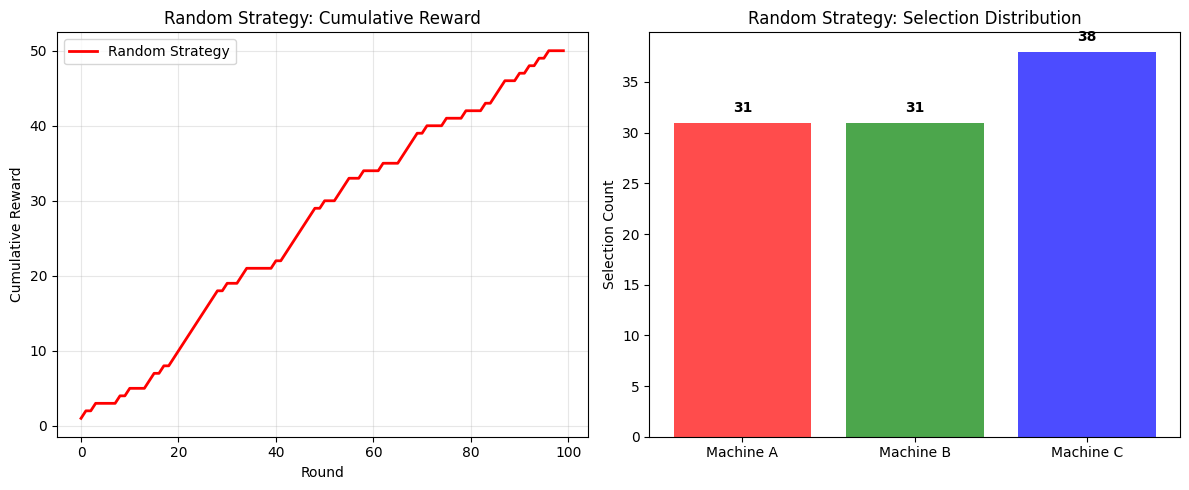

In [8]:
# 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(random_history, 'r-', linewidth=2, label='Random Strategy')  # 랜덤 전략
plt.xlabel('Round')  # 라운드
plt.ylabel('Cumulative Reward')  # 누적 보상
plt.title('Random Strategy: Cumulative Reward')  # 랜덤 전략: 누적 보상
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 2, 2)
machine_labels = ['Machine A', 'Machine B', 'Machine C']  # 머신 A, B, C
plt.bar(machine_labels, choice_counts, color=['red', 'green', 'blue'], alpha=0.7)
plt.ylabel('Selection Count')  # 선택 횟수
plt.title('Random Strategy: Selection Distribution')  # 랜덤 전략: 선택 분포
for i, count in enumerate(choice_counts):
    plt.text(i, count + 1, str(count), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

🎯 전략 2: 탐욕적 선택 (순수 활용)
- 특징: 초기 탐험 후 가장 좋은 머신만 계속 선택
- 장점: 알려진 최선의 선택을 최대한 활용
- 단점: 더 좋은 머신이 있어도 발견하지 못함

In [9]:
def greedy_strategy(n_rounds):
    """현재까지 가장 좋은 머신만 선택하는 전략"""
    # 초기에 각 머신을 한 번씩 시도
    arm_counts = np.ones(n_arms)  # 각 머신을 선택한 횟수
    arm_rewards = np.zeros(n_arms)  # 각 머신에서 받은 총 보상
    choices_history = []
    
    # 초기 탐험: 각 머신을 한 번씩
    for i in range(n_arms):
        reward = get_reward(i)
        arm_rewards[i] += reward
        choices_history.append(i)
    
    total_reward = np.sum(arm_rewards)
    rewards_history = [total_reward]
    
    print(f"초기 탐험 결과:")
    for i in range(n_arms):
        avg_reward = arm_rewards[i] / arm_counts[i]
        print(f"  {arm_names[i]}: {int(arm_rewards[i])}/1 = {avg_reward:.3f}")
    
    # 나머지 라운드에서는 가장 좋은 머신만 선택
    for round_num in range(n_arms, n_rounds):
        # 평균 보상이 가장 높은 머신 선택
        avg_rewards = arm_rewards / arm_counts
        best_arm = np.argmax(avg_rewards)
        choices_history.append(best_arm)
        
        # 보상 받기
        reward = get_reward(best_arm)
        arm_counts[best_arm] += 1
        arm_rewards[best_arm] += reward
        total_reward += reward
        rewards_history.append(total_reward)
    
    return total_reward, rewards_history, choices_history, arm_counts, arm_rewards

# 탐욕적 전략 실행
greedy_total, greedy_history, greedy_choices, greedy_counts, greedy_rewards = greedy_strategy(n_rounds)

초기 탐험 결과:
  슬롯머신 A: 0/1 = 0.000
  슬롯머신 B: 1/1 = 1.000
  슬롯머신 C: 1/1 = 1.000


In [10]:
print(f"최종 결과:")
print(f"총 누적 보상: {greedy_total}")
print(f"평균 라운드당 보상: {greedy_total/n_rounds:.3f}")

최종 결과:
총 누적 보상: 67.0
평균 라운드당 보상: 0.670


In [11]:
# 최종 성능 분석
print(f"각 머신의 최종 성능:")
for i in range(n_arms):
    avg_reward = greedy_rewards[i] / greedy_counts[i]
    print(f"  {arm_names[i]}: {int(greedy_rewards[i])}/{int(greedy_counts[i])} = {avg_reward:.3f}")

각 머신의 최종 성능:
  슬롯머신 A: 0/1 = 0.000
  슬롯머신 B: 66/97 = 0.680
  슬롯머신 C: 1/2 = 0.500


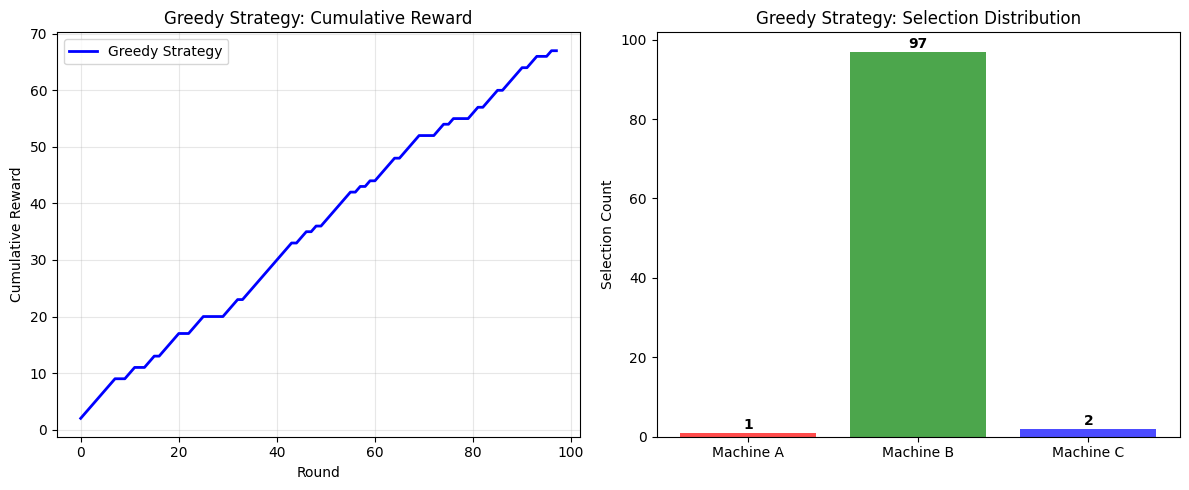

In [12]:
# 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(greedy_history, 'b-', linewidth=2, label='Greedy Strategy')  # 탐욕적 전략
plt.xlabel('Round')  # 라운드
plt.ylabel('Cumulative Reward')  # 누적 보상
plt.title('Greedy Strategy: Cumulative Reward')  # 탐욕적 전략: 누적 보상
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 2, 2)
machine_labels = ['Machine A', 'Machine B', 'Machine C']  # 머신 A, B, C
final_counts = [int(count) for count in greedy_counts]
plt.bar(machine_labels, final_counts, color=['red', 'green', 'blue'], alpha=0.7)
plt.ylabel('Selection Count')  # 선택 횟수
plt.title('Greedy Strategy: Selection Distribution')  # 탐욕적 전략: 선택 분포
for i, count in enumerate(final_counts):
    plt.text(i, count + 1, str(count), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

⚖️ 전략 3: 엡실론-탐욕적 선택 (균형)<br>
- 특징: 10.0% 확률로 탐험, 90.0% 확률로 활용<br>
- 장점: 탐험과 활용의 균형으로 안정적 성능<br>
- 단점: 항상 약간의 비효율성 존재

In [13]:
epsilon = 0.1
print(f"특징: {epsilon*100}% 확률로 탐험, {(1-epsilon)*100}% 확률로 활용")

def epsilon_greedy_strategy(n_rounds, epsilon=0.1):
    """엡실론 확률로 탐험, 나머지는 활용하는 전략"""
    arm_counts = np.ones(n_arms)
    arm_rewards = np.zeros(n_arms)
    choices_history = []
    exploration_history = []  # 탐험인지 활용인지 기록
    
    # 초기 탐험
    for i in range(n_arms):
        reward = get_reward(i)
        arm_rewards[i] += reward
        choices_history.append(i)
        exploration_history.append(True)  # 초기는 모두 탐험
    
    total_reward = np.sum(arm_rewards)
    rewards_history = [total_reward]
    
    print(f"초기 탐험 결과:")
    for i in range(n_arms):
        avg_reward = arm_rewards[i] / arm_counts[i]
        print(f"  {arm_names[i]}: {int(arm_rewards[i])}/1 = {avg_reward:.3f}")
    
    for round_num in range(n_arms, n_rounds):
        # 엡실론 확률로 탐험 vs 활용 결정
        if np.random.random() < epsilon:
            # 탐험: 랜덤 선택
            chosen_arm = np.random.randint(0, n_arms)
            exploration_history.append(True)
        else:
            # 활용: 가장 좋은 머신 선택
            avg_rewards = arm_rewards / arm_counts
            chosen_arm = np.argmax(avg_rewards)
            exploration_history.append(False)
        
        choices_history.append(chosen_arm)
        
        # 보상 받기
        reward = get_reward(chosen_arm)
        arm_counts[chosen_arm] += 1
        arm_rewards[chosen_arm] += reward
        total_reward += reward
        rewards_history.append(total_reward)
    
    return total_reward, rewards_history, choices_history, arm_counts, arm_rewards, exploration_history

# 엡실론-탐욕적 전략 실행
epsilon_total, epsilon_history, epsilon_choices, epsilon_counts, epsilon_rewards, exploration_record = epsilon_greedy_strategy(n_rounds, epsilon=0.1)

특징: 10.0% 확률로 탐험, 90.0% 확률로 활용
초기 탐험 결과:
  슬롯머신 A: 0/1 = 0.000
  슬롯머신 B: 1/1 = 1.000
  슬롯머신 C: 1/1 = 1.000


In [14]:
print(f"\n최종 결과:")
print(f"총 누적 보상: {epsilon_total}")
print(f"평균 라운드당 보상: {epsilon_total/n_rounds:.3f}")


최종 결과:
총 누적 보상: 57.0
평균 라운드당 보상: 0.570


In [15]:
# 탐험/활용 분석
exploration_count = sum(exploration_record)
exploitation_count = len(exploration_record) - exploration_count
print(f"탐험 횟수: {exploration_count} ({exploration_count/n_rounds*100:.1f}%)")
print(f"활용 횟수: {exploitation_count} ({exploitation_count/n_rounds*100:.1f}%)")

탐험 횟수: 16 (16.0%)
활용 횟수: 84 (84.0%)


In [16]:
# 최종 성능 분석
print(f"\n각 머신의 최종 성능:")
for i in range(n_arms):
    avg_reward = epsilon_rewards[i] / epsilon_counts[i]
    print(f"  {arm_names[i]}: {int(epsilon_rewards[i])}/{int(epsilon_counts[i])} = {avg_reward:.3f}")


각 머신의 최종 성능:
  슬롯머신 A: 1/6 = 0.167
  슬롯머신 B: 32/47 = 0.681
  슬롯머신 C: 24/47 = 0.511


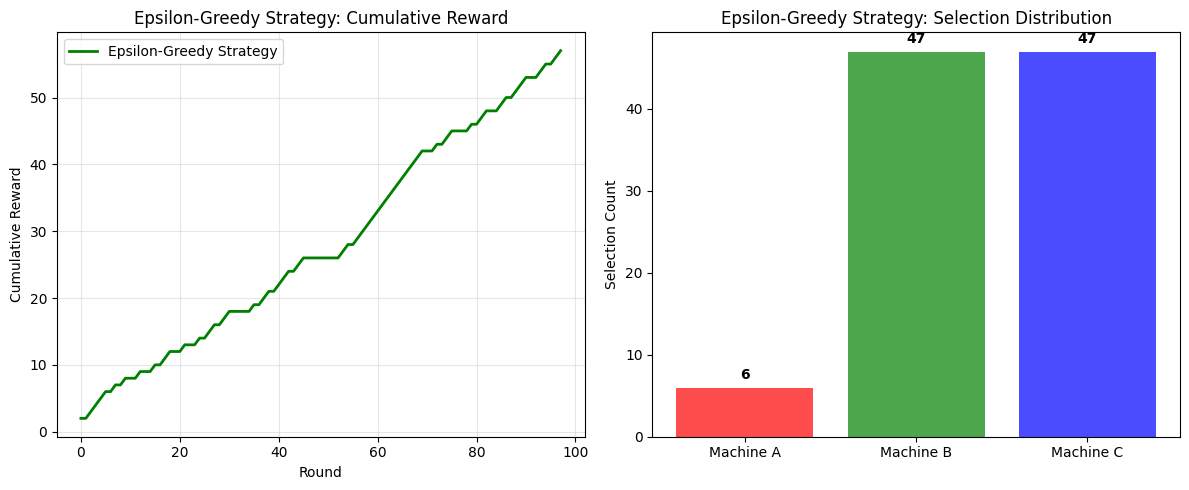

In [17]:
# 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epsilon_history, 'g-', linewidth=2, label='Epsilon-Greedy Strategy')  # 엡실론-탐욕적 전략
plt.xlabel('Round')  # 라운드
plt.ylabel('Cumulative Reward')  # 누적 보상
plt.title('Epsilon-Greedy Strategy: Cumulative Reward')  # 엡실론-탐욕적 전략: 누적 보상
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 2, 2)
machine_labels = ['Machine A', 'Machine B', 'Machine C']  # 머신 A, B, C
final_counts = [int(count) for count in epsilon_counts]
plt.bar(machine_labels, final_counts, color=['red', 'green', 'blue'], alpha=0.7)
plt.ylabel('Selection Count')  # 선택 횟수
plt.title('Epsilon-Greedy Strategy: Selection Distribution')  # 엡실론-탐욕적 전략: 선택 분포
for i, count in enumerate(final_counts):
    plt.text(i, count + 1, str(count), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

### 전략별 종합 비교

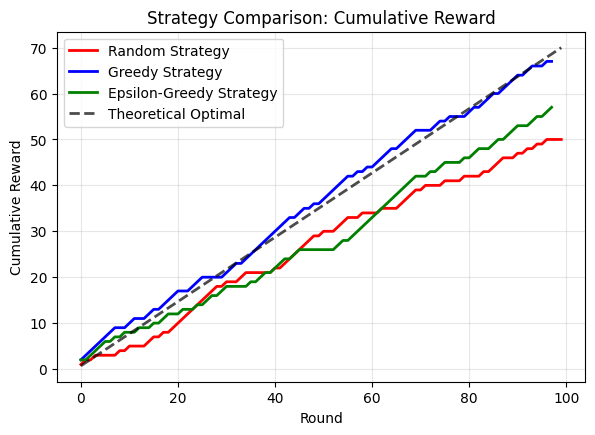

In [18]:
# 결과 시각화
plt.figure(figsize=(15, 10))

# 1. 누적 보상 비교
plt.subplot(2, 2, 1)
plt.plot(random_history, 'r-', linewidth=2, label='Random Strategy')  # 랜덤 전략
plt.plot(greedy_history, 'b-', linewidth=2, label='Greedy Strategy')  # 탐욕적 전략
plt.plot(epsilon_history, 'g-', linewidth=2, label='Epsilon-Greedy Strategy')  # 엡실론-탐욕적 전략

# 최적 누적 보상 (항상 최고 머신 선택 시)
optimal_reward = max(true_rewards)
optimal_history = [optimal_reward * i for i in range(1, n_rounds + 1)]
plt.plot(optimal_history, 'k--', linewidth=2, label='Theoretical Optimal', alpha=0.7)  # 이론적 최적

plt.xlabel('Round')  # 라운드
plt.ylabel('Cumulative Reward')  # 누적 보상
plt.title('Strategy Comparison: Cumulative Reward')  # 전략 비교: 누적 보상
plt.legend()
plt.grid(True, alpha=0.3)

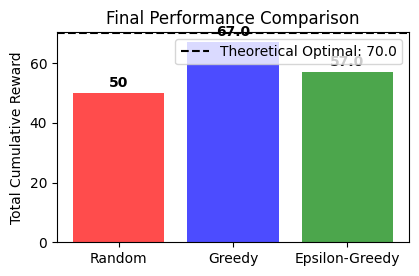

In [19]:
# 2. 최종 성과 비교
plt.subplot(2, 2, 2)
strategies = ['Random', 'Greedy', 'Epsilon-Greedy']  # 랜덤, 탐욕적, 엡실론-탐욕적
totals = [random_total, greedy_total, epsilon_total]
colors = ['red', 'blue', 'green']

bars = plt.bar(strategies, totals, color=colors, alpha=0.7)
plt.ylabel('Total Cumulative Reward')  # 총 누적 보상
plt.title('Final Performance Comparison')  # 최종 성과 비교
plt.axhline(y=optimal_reward * n_rounds, color='black', linestyle='--', 
           label=f'Theoretical Optimal: {optimal_reward * n_rounds}')  # 이론적 최적
plt.legend()

# 막대 위에 수치 표시
for bar, total in zip(bars, totals):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             str(total), ha='center', va='bottom', fontweight='bold')

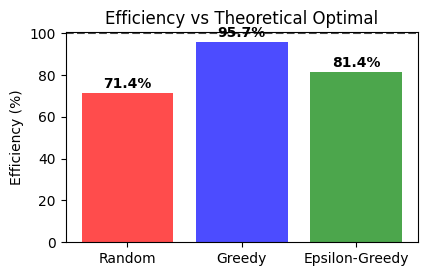

In [20]:
# 3. 효율성 비교 (이론적 최적 대비 비율)
plt.subplot(2, 2, 3)
optimal_total = optimal_reward * n_rounds
efficiency = [total/optimal_total*100 for total in totals]

bars = plt.bar(strategies, efficiency, color=colors, alpha=0.7)
plt.ylabel('Efficiency (%)')  # 효율성 (%)
plt.title('Efficiency vs Theoretical Optimal')  # 이론적 최적 대비 효율성
plt.axhline(y=100, color='black', linestyle='--', alpha=0.7)

for bar, eff in zip(bars, efficiency):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{eff:.1f}%', ha='center', va='bottom', fontweight='bold')

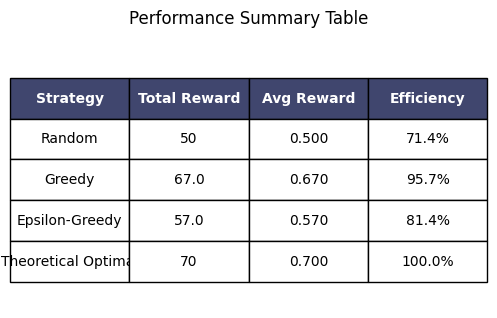

In [21]:
# 4. 성능 요약 테이블
plt.subplot(2, 2, 4)
plt.axis('off')

# 요약 데이터 (영어로 변경)
summary_data = [
    ['Strategy', 'Total Reward', 'Avg Reward', 'Efficiency'],  # 전략, 총 보상, 평균 보상, 효율성
    ['Random', f'{random_total}', f'{random_total/n_rounds:.3f}', f'{efficiency[0]:.1f}%'],  # 랜덤
    ['Greedy', f'{greedy_total}', f'{greedy_total/n_rounds:.3f}', f'{efficiency[1]:.1f}%'],  # 탐욕적
    ['Epsilon-Greedy', f'{epsilon_total}', f'{epsilon_total/n_rounds:.3f}', f'{efficiency[2]:.1f}%'],  # 엡실론-탐욕적
    ['Theoretical Optimal', f'{int(optimal_total)}', f'{optimal_reward:.3f}', '100.0%']  # 이론적 최적
]

table = plt.table(cellText=summary_data[1:], colLabels=summary_data[0],
                  loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# 헤더 스타일
for i in range(len(summary_data[0])):
    table[(0, i)].set_facecolor('#40466e')
    table[(0, i)].set_text_props(weight='bold', color='white')

plt.title('Performance Summary Table', pad=20)  # 성능 요약 테이블

plt.tight_layout()
plt.show()

In [22]:
# 수치 요약
print("\n📈 성능 요약:")
print(f"Random Strategy        : {random_total}점 ({efficiency[0]:4.1f}% 효율성)")  # 랜덤 전략
print(f"Greedy Strategy        : {int(greedy_total)}점 ({efficiency[1]:4.1f}% 효율성)")  # 탐욕적 전략
print(f"Epsilon-Greedy Strategy: {int(epsilon_total)}점 ({efficiency[2]:4.1f}% 효율성)")  # 엡실론-탐욕적 전략
print(f"Theoretical Optimal    : {int(optimal_total):2d}점 (100.0% 효율성)")  # 이론적 최적

print("\n🏆 승자: ", end="")
winner_idx = np.argmax(totals)
print(f"{strategies[winner_idx]} Strategy!")  # 전략


📈 성능 요약:
Random Strategy        : 50점 (71.4% 효율성)
Greedy Strategy        : 67점 (95.7% 효율성)
Epsilon-Greedy Strategy: 57점 (81.4% 효율성)
Theoretical Optimal    : 70점 (100.0% 효율성)

🏆 승자: Greedy Strategy!


## 순차적 의사결정의 핵심
- 각 결정이 미래에 영향을 미침
- 즉각적 보상 vs 장기적 보상의 트레이드오프
- 탐험(새로운 선택지 시도) vs 활용(알려진 최선 선택)의 균형
- 이것이 강화학습의 기본 딜레마!

------

## Chapter 2: 마르코프 프로세스 계층 (MP → MRP → MDP)

마르코프 성질<br>
- 미래는 오직 현재 상태에만 의존함<br>
- 과거 상태는 현재 상태에 이미 반영되어 있음<br>
- P(다음상태 | 현재상태, 과거상태들) = P(다음상태 | 현재상태)

### 2-1. 마르코프 프로세스 (MP): 아이의 잠드는 과정

In [23]:
# 상태 정의
states = ['누워있음', '일어나서놈', '눈감음', '잠이옴', '잠듦']
n_states = len(states)
state_to_idx = {state: i for i, state in enumerate(states)}

print("상태 공간:", states)

상태 공간: ['누워있음', '일어나서놈', '눈감음', '잠이옴', '잠듦']


In [24]:
# 전이 확률 행렬 정의 
P = np.array([
    [0.0, 0.4, 0.6, 0.0, 0.0],  # 누워있음 → 다른 상태들
    [0.1, 0.6, 0.3, 0.0, 0.0],  # 일어나서놈 → 다른 상태들  
    [0.0, 0.3, 0.0, 0.7, 0.0],  # 눈감음 → 다른 상태들
    [0.0, 0.0, 0.0, 0.0, 1.0],  # 잠이옴 → 잠듦 (확실)
    [0.0, 0.0, 0.0, 0.0, 1.0]   # 잠듦 → 잠듦 (종료상태)
])

print(f"전이 확률 행렬 (5x5):")
print("행: 현재 상태, 열: 다음 상태")

전이 확률 행렬 (5x5):
행: 현재 상태, 열: 다음 상태


In [25]:
# 전이 확률 행렬을 DataFrame으로 보기 좋게 출력
df_transition = pd.DataFrame(P, index=states, columns=states)
df_transition.head(10)

,누워있음,일어나서놈,눈감음,잠이옴,잠듦
누워있음,0.0,0.4,0.6,0.0,0.0
일어나서놈,0.1,0.6,0.3,0.0,0.0
눈감음,0.0,0.3,0.0,0.7,0.0
잠이옴,0.0,0.0,0.0,0.0,1.0
잠듦,0.0,0.0,0.0,0.0,1.0


In [26]:
# 각 행의 합이 1인지 확인 (확률의 기본 조건)
row_sums = P.sum(axis=1)
print(f"각 행의 합: {row_sums}")

각 행의 합: [1. 1. 1. 1. 1.]


In [27]:
# 마르코프 체인 시뮬레이션
def simulate_markov_chain(P, start_state, n_steps=10):
    """마르코프 체인 시뮬레이션"""
    current_state = start_state
    path = [current_state]
    
    for step in range(n_steps):
        # 현재 상태에서 다음 상태 확률 분포
        next_probs = P[current_state]
        
        # 확률에 따라 다음 상태 선택
        next_state = np.random.choice(n_states, p=next_probs)
        path.append(next_state)
        current_state = next_state
        
        # 잠듦 상태에 도달하면 종료
        if current_state == 4:  # 잠듦 상태
            break
    
    return path

# 여러 번 시뮬레이션 실행
print("마르코프 체인 시뮬레이션 (누워있음에서 시작):")

np.random.seed(42)
for episode in range(5):
    path_indices = simulate_markov_chain(P, start_state=0, n_steps=10)
    path_names = [states[i] for i in path_indices]
    
    print(f"에피소드 {episode+1}: {' → '.join(path_names)}")

마르코프 체인 시뮬레이션 (누워있음에서 시작):
에피소드 1: 누워있음 → 일어나서놈 → 눈감음 → 잠이옴 → 잠듦
에피소드 2: 누워있음 → 일어나서놈 → 일어나서놈 → 누워있음 → 눈감음 → 잠이옴 → 잠듦
에피소드 3: 누워있음 → 일어나서놈 → 눈감음 → 잠이옴 → 잠듦
에피소드 4: 누워있음 → 일어나서놈 → 일어나서놈 → 일어나서놈 → 일어나서놈 → 일어나서놈 → 일어나서놈 → 일어나서놈 → 일어나서놈 → 일어나서놈 → 일어나서놈
에피소드 5: 누워있음 → 눈감음 → 잠이옴 → 잠듦


### 2-2. 마르코프 보상 프로세스 (MRP): 보상 추가

In [28]:
# 보상 함수 정의 (각 상태에서 받는 보상)
rewards = np.array([-1, -1, -1, 0, 10])  # 상태별 보상
reward_dict = dict(zip(states, rewards))

print("각 상태에서 받는 보상:")
for state, reward in reward_dict.items():
    print(f"  {state}: {reward:+.0f}")

각 상태에서 받는 보상:
  누워있음: -1
  일어나서놈: -1
  눈감음: -1
  잠이옴: +0
  잠듦: +10


In [29]:
# 감쇠인자 (할인율) 정의
gamma = 0.9
print(f"감쇠인자 (할인율): {gamma}")
print("• 미래 보상을 현재 가치로 환산하는 비율")
print("• 0에 가까울수록 즉각적 보상 중시, 1에 가까울수록 미래 보상도 중시")

감쇠인자 (할인율): 0.9
• 미래 보상을 현재 가치로 환산하는 비율
• 0에 가까울수록 즉각적 보상 중시, 1에 가까울수록 미래 보상도 중시


In [30]:
# 리턴(Return) 계산하는 함수
def calculate_return(path_indices, rewards, gamma):
    """경로에서 리턴(누적 할인 보상) 계산"""
    total_return = 0
    
    for t, state_idx in enumerate(path_indices):
        discount = gamma ** t
        reward = rewards[state_idx]
        total_return += discount * reward
    
    return total_return

# 여러 에피소드에서 리턴 계산
print("\n리턴(Return) 계산 예제:")

returns = []
np.random.seed(42)

for episode in range(5):
    path_indices = simulate_markov_chain(P, start_state=0, n_steps=10)
    path_names = [states[i] for i in path_indices]
    episode_return = calculate_return(path_indices, rewards, gamma)
    
    returns.append(episode_return)
    
    print(f"\n에피소드 {episode+1}:")
    print(f"  경로: {' → '.join(path_names)}")
    print(f"  리턴: {episode_return:.2f}")


리턴(Return) 계산 예제:

에피소드 1:
  경로: 누워있음 → 일어나서놈 → 눈감음 → 잠이옴 → 잠듦
  리턴: 3.85

에피소드 2:
  경로: 누워있음 → 일어나서놈 → 일어나서놈 → 누워있음 → 눈감음 → 잠이옴 → 잠듦
  리턴: 1.22

에피소드 3:
  경로: 누워있음 → 일어나서놈 → 눈감음 → 잠이옴 → 잠듦
  리턴: 3.85

에피소드 4:
  경로: 누워있음 → 일어나서놈 → 일어나서놈 → 일어나서놈 → 일어나서놈 → 일어나서놈 → 일어나서놈 → 일어나서놈 → 일어나서놈 → 일어나서놈 → 일어나서놈
  리턴: -6.86

에피소드 5:
  경로: 누워있음 → 눈감음 → 잠이옴 → 잠듦
  리턴: 5.39


In [31]:
# 상태 가치 함수 추정 (여러 에피소드 평균)
average_return = np.mean(returns)
print(f"\n'누워있음' 상태의 추정 가치 함수: {average_return:.2f}")
print("(5번의 에피소드 평균 리턴)")


'누워있음' 상태의 추정 가치 함수: 1.49
(5번의 에피소드 평균 리턴)


### 2-3. 마르코프 결정 프로세스 (MDP): 행동 선택 추가

In [32]:
# 행동 공간 정의
actions = ['자장가부르기', '같이놀아주기']
n_actions = len(actions)
action_to_idx = {action: i for i, action in enumerate(actions)}

print("행동 공간:", actions)

행동 공간: ['자장가부르기', '같이놀아주기']


In [33]:
# 상태-행동별 전이 확률 정의 (3차원 배열)
# P_mdp[s][a][s'] = 상태 s에서 행동 a를 했을 때 상태 s'로 갈 확률
P_mdp = np.zeros((n_states, n_actions, n_states))

# 자장가부르기 (행동 0)의 전이 확률
P_mdp[0, 0] = [0.0, 0.0, 1.0, 0.0, 0.0]  # 누워있음 + 자장가 → 눈감음
P_mdp[1, 0] = [0.0, 0.0, 1.0, 0.0, 0.0]  # 일어나서놈 + 자장가 → 눈감음
P_mdp[2, 0] = [0.0, 0.0, 0.0, 1.0, 0.0]  # 눈감음 + 자장가 → 잠이옴
P_mdp[3, 0] = [0.0, 0.0, 0.0, 0.0, 1.0]  # 잠이옴 + 자장가 → 잠듦
P_mdp[4, 0] = [0.0, 0.0, 0.0, 0.0, 1.0]  # 잠듦 + 자장가 → 잠듦

# 같이놀아주기 (행동 1)의 전이 확률  
P_mdp[0, 1] = [0.0, 1.0, 0.0, 0.0, 0.0]  # 누워있음 + 놀기 → 일어나서놈
P_mdp[1, 1] = [0.0, 1.0, 0.0, 0.0, 0.0]  # 일어나서놈 + 놀기 → 일어나서놈  
P_mdp[2, 1] = [0.0, 1.0, 0.0, 0.0, 0.0]  # 눈감음 + 놀기 → 일어나서놈
P_mdp[3, 1] = [0.0, 1.0, 0.0, 0.0, 0.0]  # 잠이옴 + 놀기 → 일어나서놈
P_mdp[4, 1] = [0.0, 0.0, 0.0, 0.0, 1.0]  # 잠듦 + 놀기 → 잠듦

# 상태-행동별 보상 정의
R_mdp = np.array([
    [-1, -1],  # 누워있음에서 행동별 보상
    [-1, -1],  # 일어나서놈에서 행동별 보상
    [-1, -1],  # 눈감음에서 행동별 보상  
    [0, -2],   # 잠이옴에서 행동별 보상
    [10, 10]   # 잠듦에서 행동별 보상
])

In [34]:
print("상태-행동별 전이 확률 예제:")
print("'누워있음' 상태에서:")
for i, action in enumerate(actions):
    next_state_probs = P_mdp[0, i]
    print(f"  {action}:")
    for j, prob in enumerate(next_state_probs):
        if prob > 0:
            print(f"    → {states[j]}: {prob:.1f}")

print("\n상태-행동별 보상:")
for i, state in enumerate(states):
    print(f"{state}:")
    for j, action in enumerate(actions):
        print(f"  {action}: {R_mdp[i, j]:+.0f}")

상태-행동별 전이 확률 예제:
'누워있음' 상태에서:
  자장가부르기:
    → 눈감음: 1.0
  같이놀아주기:
    → 일어나서놈: 1.0

상태-행동별 보상:
누워있음:
  자장가부르기: -1
  같이놀아주기: -1
일어나서놈:
  자장가부르기: -1
  같이놀아주기: -1
눈감음:
  자장가부르기: -1
  같이놀아주기: -1
잠이옴:
  자장가부르기: +0
  같이놀아주기: -2
잠듦:
  자장가부르기: +10
  같이놀아주기: +10


In [35]:
# 정책 정의 (각 상태에서 행동 선택 확률)
def create_policy(policy_type="random"):
    """정책 생성 함수"""
    policy = np.zeros((n_states, n_actions))
    
    if policy_type == "random":
        # 랜덤 정책: 모든 행동을 동일 확률로
        policy[:] = 1.0 / n_actions
    elif policy_type == "lullaby_focused":
        # 자장가 중심 정책
        policy[:, 0] = 0.8  # 자장가 80%
        policy[:, 1] = 0.2  # 놀기 20%
    elif policy_type == "play_focused":
        # 놀기 중심 정책  
        policy[:, 0] = 0.2  # 자장가 20%
        policy[:, 1] = 0.8  # 놀기 80%
    
    return policy

# 다양한 정책 생성
random_policy = create_policy("random")
lullaby_policy = create_policy("lullaby_focused")  
play_policy = create_policy("play_focused")

print("정책 예제 (자장가 중심 정책):")
print("각 상태에서 행동 선택 확률:")
policy_df = pd.DataFrame(lullaby_policy, 
                        index=states, 
                        columns=actions)
print(policy_df.round(2))

정책 예제 (자장가 중심 정책):
각 상태에서 행동 선택 확률:
       자장가부르기  같이놀아주기
누워있음      0.8     0.2
일어나서놈     0.8     0.2
눈감음       0.8     0.2
잠이옴       0.8     0.2
잠듦        0.8     0.2


In [36]:
# MDP에서 정책 따라 시뮬레이션
def simulate_mdp(P_mdp, R_mdp, policy, start_state, n_steps=10):
    """MDP에서 주어진 정책을 따라 시뮬레이션"""
    current_state = start_state
    path = [current_state]
    actions_taken = []
    rewards_received = []
    
    for step in range(n_steps):
        # 현재 상태에서 정책에 따라 행동 선택
        action_probs = policy[current_state]
        action = np.random.choice(n_actions, p=action_probs)
        actions_taken.append(action)
        
        # 행동에 따른 보상 받기
        reward = R_mdp[current_state, action]
        rewards_received.append(reward)
        
        # 다음 상태로 전이
        next_state_probs = P_mdp[current_state, action]
        next_state = np.random.choice(n_states, p=next_state_probs)
        
        path.append(next_state)
        current_state = next_state
        
        # 잠듦 상태에 도달하면 종료
        if current_state == 4:
            break
    
    return path, actions_taken, rewards_received

In [37]:
# 자장가 중심 정책으로 시뮬레이션
print("\n자장가 중심 정책 시뮬레이션:")
print("-" * 35)

np.random.seed(42)
path, actions_taken, rewards_received = simulate_mdp(P_mdp, R_mdp, lullaby_policy, start_state=0, n_steps=10)

print("상태 경로:", " → ".join([states[i] for i in path]))
print("행동 경로:", " → ".join([actions[i] for i in actions_taken]))
print("보상 경로:", rewards_received)

# 리턴 계산
total_return = sum(rewards_received[i] * (gamma ** i) for i in range(len(rewards_received)))
print(f"총 리턴: {total_return:.2f}")


자장가 중심 정책 시뮬레이션:
-----------------------------------
상태 경로: 누워있음 → 눈감음 → 잠이옴 → 잠듦
행동 경로: 자장가부르기 → 자장가부르기 → 자장가부르기
보상 경로: [-1, -1, 0]
총 리턴: -1.90


-----

## Chapter 3: 벨만 방정식 기초

벨만 방정식이란?<br>
- 현재 상태의 가치를 다음 상태의 가치들로 표현하는 재귀적 관계식<br>
- 동적 계획법의 기초가 되는 핵심 수식<br>
- 가치 함수를 계산하는 체계적인 방법 제공<br>

### 3-1. GridWorld 환경에서 벨만 방정식

In [38]:
# 4x4 그리드 월드 설정
grid_size = 4
n_grid_states = grid_size * grid_size

# 상태를 (행, 열) 좌표로 표현
def state_to_coord(state):
    """상태 번호를 (행, 열) 좌표로 변환"""
    return (state // grid_size, state % grid_size)

def coord_to_state(row, col):
    """(행, 열) 좌표를 상태 번호로 변환"""
    return row * grid_size + col

# 행동 정의 (상, 하, 좌, 우)
grid_actions = ['↑', '↓', '←', '→']
n_grid_actions = len(grid_actions)

# 행동에 따른 좌표 변화
action_effects = {
    0: (-1, 0),  # 상 (↑)
    1: (1, 0),   # 하 (↓)  
    2: (0, -1),  # 좌 (←)
    3: (0, 1)    # 우 (→)
}

print("GridWorld 환경 설정:")
print(f"• 크기: {grid_size}x{grid_size}")
print(f"• 총 상태 수: {n_grid_states}")
print(f"• 행동: {grid_actions}")

GridWorld 환경 설정:
• 크기: 4x4
• 총 상태 수: 16
• 행동: ['↑', '↓', '←', '→']


In [39]:
# 전이 함수 정의
def get_next_state(state, action):
    """현재 상태에서 행동을 취했을 때 다음 상태 반환"""
    row, col = state_to_coord(state)
    d_row, d_col = action_effects[action]
    
    # 새로운 위치 계산
    new_row = row + d_row
    new_col = col + d_col
    
    # 경계 체크
    if 0 <= new_row < grid_size and 0 <= new_col < grid_size:
        return coord_to_state(new_row, new_col)
    else:
        # 벽에 부딧히면 현재 상태 유지
        return state

# 보상 함수 정의 (목표 상태 설정)
goal_state = coord_to_state(3, 3)  # 우하단 모서리
grid_rewards = np.full(n_grid_states, -1)  # 모든 상태에서 -1 보상
grid_rewards[goal_state] = 10  # 목표 상태에서는 +10

print(f"보상 설정:")
print(f"• 일반 상태: -1 (이동 비용)")
print(f"• 목표 상태 (3,3): +10")

보상 설정:
• 일반 상태: -1 (이동 비용)
• 목표 상태 (3,3): +10


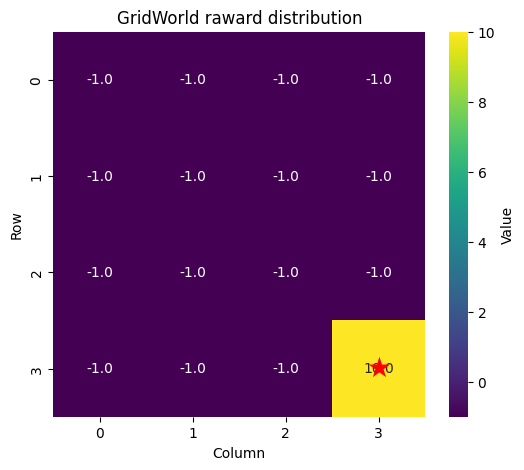

In [40]:
# 그리드 시각화
def visualize_grid(values, title="GridWorld"):
    """그리드 형태로 값들을 시각화"""
    grid_values = values.reshape(grid_size, grid_size)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(grid_values, annot=True, fmt='.1f', cmap='viridis',
                cbar_kws={'label': 'Value'})
    plt.title(title)
    plt.xlabel('Column')
    plt.ylabel('Row')
    
    # 목표 상태 표시
    goal_row, goal_col = state_to_coord(goal_state)
    plt.text(goal_col + 0.5, goal_row + 0.5, '★', 
             ha='center', va='center', color='red', fontsize=20)
    
    plt.show()

# 보상 분포 시각화
visualize_grid(grid_rewards, "GridWorld raward distribution")

### 3-2. 벨만 방정식을 이용한 가치 함수 계산

In [41]:
# 균등 정책 (모든 행동을 동일 확률로 선택)
uniform_policy = np.ones((n_grid_states, n_grid_actions)) / n_grid_actions

print("균등 정책 사용: 각 상태에서 모든 행동을 25% 확률로 선택")
uniform_policy

균등 정책 사용: 각 상태에서 모든 행동을 25% 확률로 선택


array([[0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25]])

In [42]:
# 벨만 방정식: V(s) = Σ_a π(a|s) * [R(s,a) + γ * Σ_s' P(s'|s,a) * V(s')]
def bellman_equation_step(V, policy, rewards, gamma=0.9):
    """벨만 방정식을 한 단계 업데이트"""
    V_new = np.zeros(n_grid_states)
    
    for state in range(n_grid_states):
        for action in range(n_grid_actions):
            # 정책에서 이 행동을 선택할 확률
            action_prob = policy[state, action]
            
            # 즉시 보상
            immediate_reward = rewards[state]
            
            # 다음 상태
            next_state = get_next_state(state, action)
            
            # 다음 상태의 가치 (할인 적용)
            future_value = gamma * V[next_state]
            
            # 벨만 방정식 계산
            V_new[state] += action_prob * (immediate_reward + future_value)
    
    return V_new

In [43]:
# 가치 함수를 반복적으로 업데이트 (가치 반복)
print("가치 반복 과정:")

# 초기 가치 함수 (모든 상태에서 0)
V = np.zeros(n_grid_states)
gamma = 0.9

print(f"할인율: {gamma}")
print(f"초기 가치 함수: 모든 상태에서 0")

# 반복 업데이트
for iteration in range(10):
    V_new = bellman_equation_step(V, uniform_policy, grid_rewards, gamma)
    
    # 변화량 계산
    max_change = np.max(np.abs(V_new - V))
    
    V = V_new.copy()
    
    if iteration < 5 or iteration % 2 == 0:
        print(f"반복 {iteration+1}: 최대 변화량 = {max_change:.4f}")

가치 반복 과정:
할인율: 0.9
초기 가치 함수: 모든 상태에서 0
반복 1: 최대 변화량 = 10.0000
반복 2: 최대 변화량 = 4.0500
반복 3: 최대 변화량 = 2.5312
반복 4: 최대 변화량 = 1.5263
반복 5: 최대 변화량 = 1.0354
반복 7: 최대 변화량 = 0.5029
반복 9: 최대 변화량 = 0.3617



최종 상태 가치 함수:
상태 (0,0): -6.29
상태 (0,1): -6.03
상태 (0,2): -5.53
상태 (0,3): -5.02
상태 (1,0): -6.03
상태 (1,1): -5.48
상태 (1,2): -4.30
상태 (1,3): -2.88
상태 (2,0): -5.53
상태 (2,1): -4.30
상태 (2,2): -1.31
상태 (2,3): 3.55
상태 (3,0): -5.02
상태 (3,1): -2.88
상태 (3,2): 3.55
상태 (3,3): 20.94


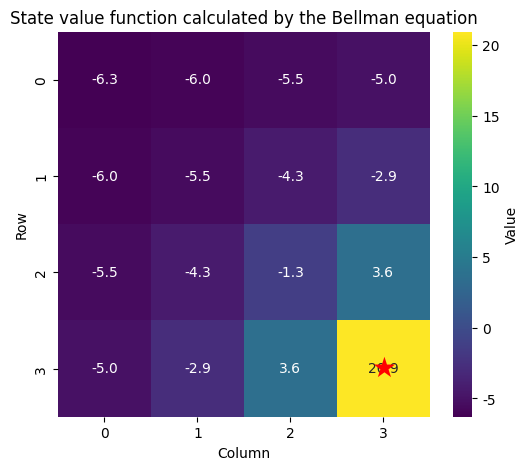

In [44]:
print(f"\n최종 상태 가치 함수:")
for i in range(n_grid_states):
    row, col = state_to_coord(i)
    print(f"상태 ({row},{col}): {V[i]:.2f}")

# 최종 가치 함수 시각화
visualize_grid(V, "State value function calculated by the Bellman equation")

### 3-3. 행동 가치 함수 (Q-함수)

In [45]:
def calculate_q_function(V, rewards, gamma=0.9):
    """상태 가치 함수로부터 행동 가치 함수 계산"""
    Q = np.zeros((n_grid_states, n_grid_actions))
    
    for state in range(n_grid_states):
        for action in range(n_grid_actions):
            # 즉시 보상
            immediate_reward = rewards[state]
            
            # 다음 상태
            next_state = get_next_state(state, action)
            
            # Q(s,a) = R(s,a) + γ * V(s')
            Q[state, action] = immediate_reward + gamma * V[next_state]
    
    return Q

# Q-함수 계산
Q = calculate_q_function(V, grid_rewards, gamma)

print("행동 가치 함수 Q(s,a) 예제:")
print("상태 (1,1)에서 각 행동의 가치:")

example_state = coord_to_state(1, 1)
for action, direction in enumerate(grid_actions):
    q_value = Q[example_state, action]
    print(f"  {direction}: {q_value:.2f}")

행동 가치 함수 Q(s,a) 예제:
상태 (1,1)에서 각 행동의 가치:
  ↑: -6.43
  ↓: -4.87
  ←: -6.43
  →: -4.87


그리디 정책 (최적 행동):
각 상태에서 선택할 최적 행동:


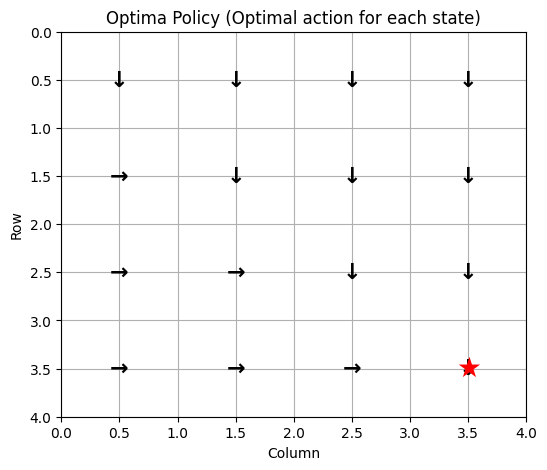

In [46]:
# 최적 정책 유도 (그리디 정책)
def derive_greedy_policy(Q):
    """Q-함수로부터 그리디 정책 유도"""
    policy = np.zeros((n_grid_states, n_grid_actions))
    
    for state in range(n_grid_states):
        # 가장 높은 Q-값을 가진 행동 선택
        best_action = np.argmax(Q[state])
        policy[state, best_action] = 1.0
    
    return policy

# 그리디 정책 계산
greedy_policy = derive_greedy_policy(Q)

print(f"그리디 정책 (최적 행동):")
print("각 상태에서 선택할 최적 행동:")

# 그리드 형태로 최적 행동 표시
optimal_actions = np.argmax(Q, axis=1)
action_grid = optimal_actions.reshape(grid_size, grid_size)

plt.figure(figsize=(6, 5))
action_symbols = np.array(['↑', '↓', '←', '→'])
action_display = action_symbols[action_grid]

# 열과 행 인덱스 생성
for i in range(grid_size):
    for j in range(grid_size):
        plt.text(j + 0.5, i + 0.5, action_display[i, j], 
                ha='center', va='center', fontsize=16, fontweight='bold')

plt.xlim(0, grid_size)
plt.ylim(0, grid_size)
plt.gca().invert_yaxis()  # y축 뒤집기 (행렬 형태로 표시)
plt.grid(True)
plt.title('Optima Policy (Optimal action for each state)')
plt.xlabel('Column')
plt.ylabel('Row')

# 목표 상태 표시
goal_row, goal_col = state_to_coord(goal_state)
plt.text(goal_col + 0.5, goal_row + 0.5, '★', 
         ha='center', va='center', color='red', fontsize=20)

plt.show()

### 3-4. 벨만 방정식의 핵심 개념<br>
벨만 방정식: V(s) = Σ_a π(a|s) * [R(s,a) + γ * Σ_s' P(s'|s,a) * V(s')]<br>
<br>
구성 요소:<br>
- V(s): 현재 상태 s의 가치<br>
- π(a|s): 상태 s에서 행동 a를 선택할 확률 (정책)<br>
- R(s,a): 상태 s에서 행동 a를 했을 때 즉시 보상<br>
- γ: 할인율 (미래 보상의 현재 가치)<br>
- P(s'|s,a): 상태 s에서 행동 a를 했을 때 상태 s'로 갈 확률<br>
<br>
의미:<br>
- 현재 상태의 가치 = 즉시 보상 + 할인된 미래 가치의 기댓값<br>
- 재귀적 구조: 상태의 가치를 다른 상태들의 가치로 표현<br>
- 동적 계획법의 기초가 되는 핵심 수식<br>
<br>
활용:<br>
- 정책 평가: 주어진 정책의 성능을 수치적으로 계산<br>
- 정책 개선: 더 나은 정책을 찾는 기준 제공<br>
- Q-학습, SARSA 등 강화학습 알고리즘의 이론적 기반

## Chapter 1-3 정리

✓ Chapter 1: 순차적 의사결정
  - Multi-Armed Bandit으로 탐험 vs 활용 딜레마 이해
  - 강화학습의 기본 개념과 다른 학습 방법과의 차이점

✓ Chapter 2: 마르코프 프로세스 계층
  - MP: 상태 전이만 고려
  - MRP: 보상 추가로 상태의 가치 평가 가능
  - MDP: 행동 선택 추가로 최적 정책 학습 가능

✓ Chapter 3: 벨만 방정식
  - 상태 가치 함수와 행동 가치 함수의 관계
  - 재귀적 구조를 통한 가치 함수 계산
  - 최적 정책 도출의 수학적 기반

다음 단계:
- 동적 계획법으로 최적 정책 찾기
- 샘플링을 통한 학습 (MC, TD, Q-Learning)
- 신경망을 활용한 현대적 강화학습